# Image Caption Generator Using ResNet and Transformer Decoder Model

## Introduction
This proposal outlines the development of an advanced system integrating image captioning with voice output. Targeted to assist visually impaired individuals, the system employs deep learning techniques using PyTorch. The aim is to convert visual data into descriptive audio feedback for the users.

## Problem Statement
Visually impaired people often depend on assistive technologies for understanding their environment. However, many existing solutions fall short in providing detailed and contextual information about their surroundings. Our project addresses this need by developing a system that describes images but also conveys it via voice output.

---

## Development method of Image Caption Generator:
This Notebook details the creation of Image Caption Generator. The process is built upon two primary components:

### Step 1: Generating Image Features with ResNet
- This step involves utilizing the ResNet architecture to extract feature representations from images. These features form the backbone of our caption generation model.

### Step 2: Training the Transformer Decoder Model
- In this phase, we train a Transformer Decoder Model. The model's objective is to predict the subsequent word in a caption, given a sequence of preceding words (tokens) and the image features extracted in Step 1. This approach allows for the generation of contextually relevant and coherent image captions.

---

## Importing required librarires

In [ ]:
#!pip install opendatasets
import opendatasets as od
import pandas as pd

import numpy as np

import os

from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from collections import Counter

# Deep Learning and Computer Vision
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

# Additional Libraries
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import pickle
import gc
import random

# Set an option to display all columns in Pandas DataFrames
pd.set_option('display.max_colwidth', None)

## Loading dataset directly from Kaggle

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/awsaf49/coco-2017-dataset")

100%|██████████| 25.0G/25.0G [14:06<00:00, 31.8MB/s]


## Caption data Preprocessing

The code in this section would perform the following key tasks:

1. **Loading Data:**
   - Reads data from a CSV file named "captions.txt" and loads it into a Pandas DataFrame (`df`).

2. **Data Inspection:**
   - Prints the length (number of rows) of the DataFrame.
   - Displays the first 3 rows of the DataFrame for inspection.

3. **Text Preprocessing:**
   - Defines a custom function `remove_single_char_word` to remove single-character words from captions.
   - Cleans and tokenizes the 'caption' column in the DataFrame:
     - Adds `<start>` at the beginning.
     - Converts words to lowercase if they consist of alphabetic characters, or replaces them with an empty string.
     - Appends `<end>` at the end.
   - Computes the lengths of cleaned captions and determines the maximum sequence length (`max_seq_len`).
   - Removes the 'seq_len' column and ensures all captions have the same length by padding with `<pad>` tokens.

4. **Vocabulary Building:**
   - Concatenates all words from cleaned captions into a single string.
   - Creates a word frequency dictionary (`word_dict`) using the Counter class to count word occurrences.
   - Sorts words by frequency in descending order.
   - Determines the vocabulary size (`vocab_size`).

5. **Index-to-Word and Word-to-Index Mapping:**
   - Constructs two dictionaries, `index_to_word` and `word_to_index`, for mapping between word indices and words themselves.

6. **Text Sequence Conversion:**
   - Converts the 'cleaned_caption' column into sequences of word indices using the `word_to_index` mapping.
   - Stores the resulting sequences in a new column named 'text_seq'.

7. **Displaying Processed Data:**
   - Displays the first 2 rows of the DataFrame, including the newly created 'text_seq' column, for further examination.

This code prepares textual data for downstream natural language processing tasks through cleaning, tokenization, vocabulary building, and sequence conversion.

In [ ]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    # Print the GPU device name
    device = torch.device("cuda")
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using CPU.")

GPU: Tesla V100-SXM2-16GB


In [ ]:
image_path = '/content/coco-2017-dataset/coco2017/train2017'

In [ ]:
import os

# Get the list of files in the directory
file_list = os.listdir(image_path)

# Count the number of images
num_images = len(file_list)
print(f"Number of images in train2017: {num_images}")

Number of images in train2017: 118287


In [ ]:
import json

# Open the captions_train2017.json file
with open('/content/coco-2017-dataset/coco2017/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']
# Check the number of captions
num_captions = len(data)
print(f"Number of captions in captions_train2017: {num_captions}")

Number of captions in captions_train2017: 591753


In [ ]:
import pandas as pd

img_cap_pairs = []

# Iterate over each annotation in the data
for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

# Create a DataFrame from the image-caption pairs
data = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])

# Format the image paths
data['image'] = data['image'].apply(
    lambda x: f'/content/coco-2017-dataset/coco2017/train2017/{x}'
)

# Sample 40,000 captions
data = data.sample(120000)

# Reset the DataFrame index
data = data.reset_index(drop=True)

# Print the first few rows of the DataFrame
data.head()

image  \
0  /content/coco-2017-dataset/coco2017/train2017/000000560626.jpg   
1  /content/coco-2017-dataset/coco2017/train2017/000000318529.jpg   
2  /content/coco-2017-dataset/coco2017/train2017/000000461147.jpg   
3  /content/coco-2017-dataset/coco2017/train2017/000000503832.jpg   
4  /content/coco-2017-dataset/coco2017/train2017/000000066008.jpg   

                                                                        caption  
0                        a woman standing outdoors with a cat on her shoulders   
1                   Dog leaps into the air and grabs a frisbee out of the air.   
2                               a close up of a person swinging a tennis racket  
3  A group of people looking at a group of giraffes and zebras in an enclosure.  
4                         Person on surfboard riding small waves toward shore.

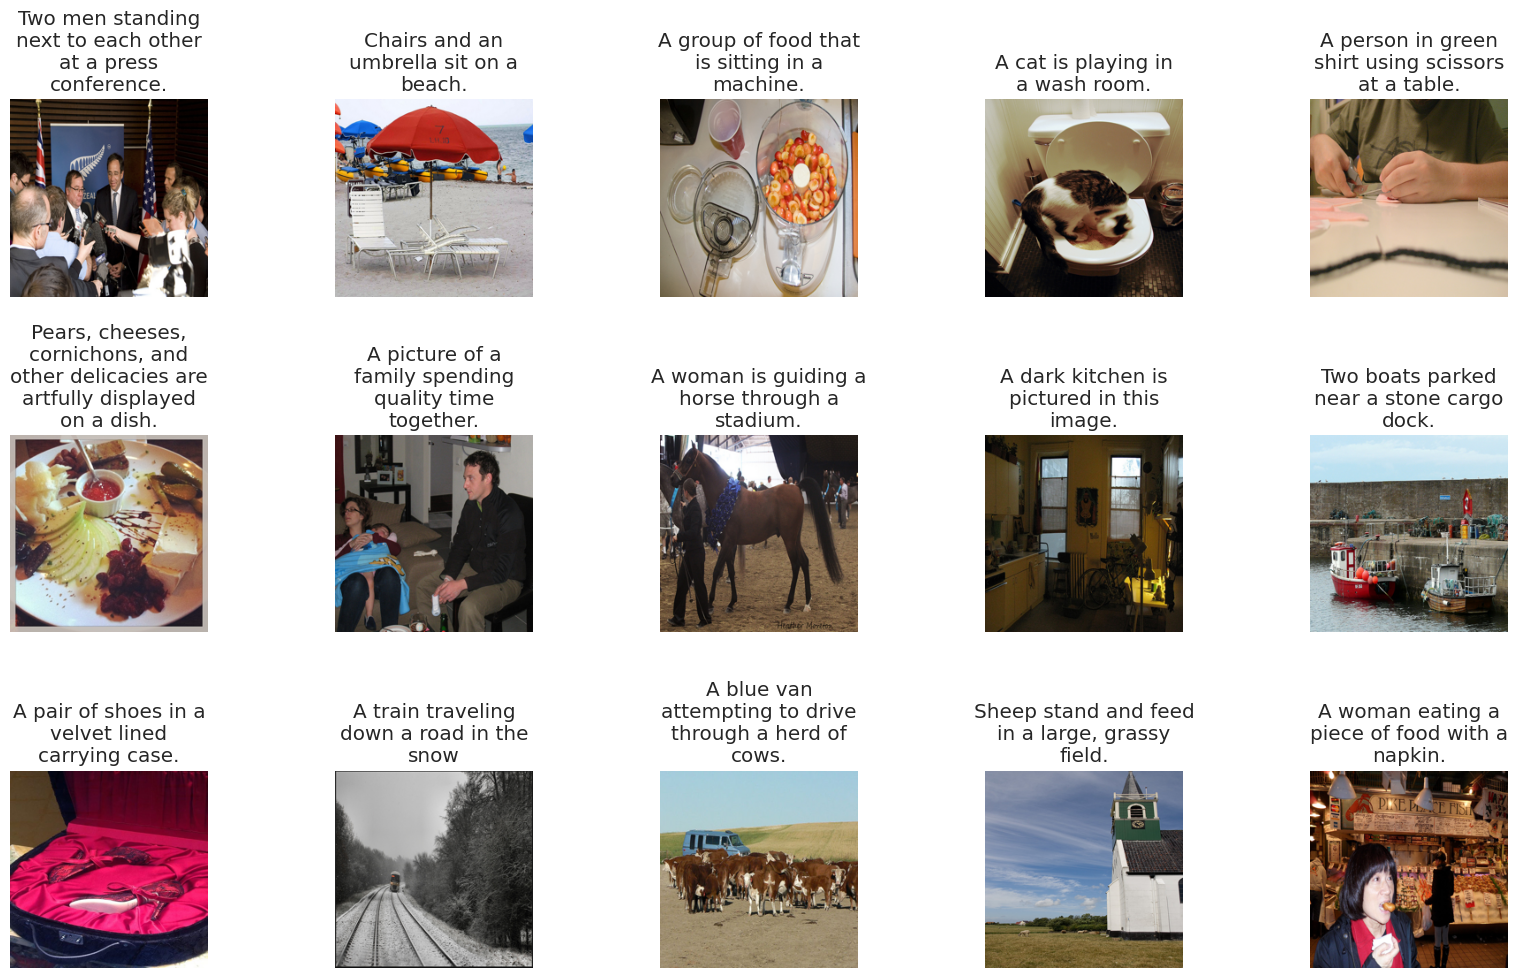

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from textwrap import wrap

def readImage(path, img_size=224):
    # Construct the full image path
    img_path = os.path.join('/content/coco-2017-dataset/coco2017/train2017', os.path.basename(path))

    # Open the image using PIL, resize it and convert to numpy array
    img = Image.open(img_path).resize((img_size, img_size))
    img = np.array(img) / 255.0

    return img

def display_images(temp_df):
    # Reset the index of the DataFrame
    temp_df = temp_df.reset_index(drop=True)

    # Create a figure with a specified size
    plt.figure(figsize=(20, 20))

    for n in range(15):
        # Create a subplot and adjust the spacing
        plt.subplot(5, 5, n + 1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)

        # Load and display the image
        image = readImage(temp_df.iloc[n]['image'])
        plt.imshow(image)

        # Wrap the caption text and set it as the title
        plt.title("\n".join(wrap(temp_df.iloc[n]['caption'], 20)))

        # Turn off the axis
        plt.axis("off")

# Call the display_images() function with a sample of 15 rows from the 'data' DataFrame
display_images(data.sample(15))

In [ ]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [ ]:
df = data.copy()

df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [ ]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

44


In [ ]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [ ]:
display(df.head(2))

image  \
0  /content/coco-2017-dataset/coco2017/train2017/000000560626.jpg   
1  /content/coco-2017-dataset/coco2017/train2017/000000318529.jpg   

                                                       caption  \
0       a woman standing outdoors with a cat on her shoulders    
1  Dog leaps into the air and grabs a frisbee out of the air.    

                                                                                                                                                                                                                                                                                                            cleaned_caption  
0  [<start>, woman, standing, outdoors, with, cat, on, her, shoulders, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]  
1                  [<start>, dog, leaps, into, the, air, and, grabs, frisbee, out, of, the, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]

In [ ]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [ ]:
print(len(word_dict))
print(word_dict[:5])

13159
['<pad>', '<start>', '<end>', 'on', 'of']


In [ ]:
vocab_size = len(word_dict)
print(vocab_size) #important to notice

13159


In [ ]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

13159 13159


In [ ]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [ ]:
len(data)

120000

## Image Data Preprocessing and Feature Extraction Using ResNet in PyTorch

The code in this section preprocesses and extracts features from the dataset of images using the ResNet model in PyTorch. The process is divided into several key steps:

1. **Sorting and Splitting the Dataset**:
   - The dataset (`df`) is first sorted based on the 'image' column.
   - It is then split into training (`train`) and validation (`valid`) sets, with 90% of the data for training and the remaining 10% for validation.

2. **Data Analysis and Preparation**:
   - The code prints the number of samples and unique images in both training and validation sets.
   - It calculates the total number of training samples.
   - It creates two subsets (`unq_train_imgs` and `unq_valid_imgs`) containing unique images from the training and validation sets, respectively.

3. **Device Configuration**:
   - The code sets up the device (GPU or CPU) for computation, depending on the availability of CUDA.

4. **Custom Dataset Class**:
   - A custom dataset class `extractImageFeatureResNetDataSet` is defined for processing the images.
   - It includes resizing, normalization, and conversion to tensor operations.

5. **DataLoader Creation**:
   - DataLoaders for both training and validation datasets are created for batch processing of the images.

6. **ResNet Model Loading and Configuration**:
   - The pre-trained ResNet18 model is loaded and set to evaluation mode.
   - The final layer (`layer4`) of ResNet18 is configured for feature extraction.

7. **Feature Extraction Function**:
   - A function `get_vector` is defined to pass an image through the ResNet model and extract features from the specified layer.

8. **Feature Extraction Process**:
   - The images from both training and validation sets are passed through the DataLoader and the `get_vector` function.
   - Extracted features are stored in dictionaries (`extract_imgFtr_ResNet_train` and `extract_imgFtr_ResNet_valid`).

9. **Saving Extracted Features**:
   - The extracted features for both training and validation sets are saved as pickle files (`EncodedImageTrainResNet.pkl` and `EncodedImageValidResNet.pkl`).

Overall, this code is a comprehensive approach to handling and extracting features from image data. It's an essential step for Image captioning.

In [ ]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [ ]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

108000 72157
12000 7987


In [ ]:
train_samples = len(train)
print(train_samples)

108000


In [ ]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

72157 7987


In [ ]:
unq_train_imgs

image
59096   /content/coco-2017-dataset/coco2017/train2017/000000000009.jpg
32031   /content/coco-2017-dataset/coco2017/train2017/000000000030.jpg
105058  /content/coco-2017-dataset/coco2017/train2017/000000000034.jpg
14981   /content/coco-2017-dataset/coco2017/train2017/000000000036.jpg
31030   /content/coco-2017-dataset/coco2017/train2017/000000000042.jpg
...                                                                ...
39371   /content/coco-2017-dataset/coco2017/train2017/000000524333.jpg
52916   /content/coco-2017-dataset/coco2017/train2017/000000524338.jpg
66492   /content/coco-2017-dataset/coco2017/train2017/000000524340.jpg
76921   /content/coco-2017-dataset/coco2017/train2017/000000524352.jpg
3721    /content/coco-2017-dataset/coco2017/train2017/000000524361.jpg

[72157 rows x 1 columns]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from torchvision import transforms
from PIL import Image

class ExtractImageFeatureResNetDataSet:
    def __init__(self, data):
        self.data = data
        # Define the transformation pipeline
        self.transform = transforms.Compose([
            transforms.Resize([224, 224]),  # Resize images to 224x224
            transforms.ToTensor(),          # Convert images to PyTorch tensors
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the tensors
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.iloc[idx]['image']
        img_loc = str(image_name)

        try:
            img = Image.open(img_loc).convert("RGB")  # Convert to RGB
            t_img = self.transform(img)
            return image_name, t_img
        except Exception as e:
            print(f"Error processing image: {image_name}")
            print(f"Error: {e}")
            # Optionally, you can handle the error more gracefully, like returning a null tensor
            return image_name, None





In [ ]:
train_ImageDataset_ResNet = ExtractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [ ]:
valid_ImageDataset_ResNet = ExtractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [ ]:
preprocessed_image = ExtractImageFeatureResNetDataSet(image_path)
TEST = DataLoader(preprocessed_image, batch_size = 1, shuffle=False)

In [ ]:
# Get one batch of data
batch = next(iter(train_ImageDataloader_ResNet))
image_names, image_tensors = batch

# Now you can check the shape of the first image tensor in the batch
print(image_tensors.shape)  # Should be [batch_size, 3, 224, 224]


torch.Size([1, 3, 224, 224])


In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [ ]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [ ]:
def get_vector(t_img):

    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)

    h.remove()
    return my_embedding

In [ ]:
image_name, t_img = next(iter(train_ImageDataloader_ResNet))
t_img = t_img.to(device)
print(t_img.shape)  # Should be [batch_size, 3, 224, 224]
embdg = get_vector(t_img)

torch.Size([1, 3, 224, 224])


In [ ]:
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):

    #print(image_name[0])
    t_img = t_img.to(device)

    embdg = get_vector(t_img)


    extract_imgFtr_ResNet_train[image_name[0]] = embdg


  0%|          | 0/72157 [00:00<?, ?it/s]

In [ ]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [ ]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/7987 [00:00<?, ?it/s]

In [ ]:
a_file = open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

## Developing a PyTorch Transformer Model for Image Captioning

This code defines our neural network model for the image captioning task using PyTorch

1. **Custom Dataset Class (`COCODataSetResnet`)**:
   - This class is designed to handle a dataset for image captioning tasks.
   - It takes two inputs: a dataset (`data`) and a file path to a pickle file (`pkl_file`) containing our previously encoded image features.
   - The `__getitem__` method returns a tuple containing the input caption sequence, target caption sequence (offset by one token for training), and the encoded image tensor.

2. **DataLoaders for Training and Validation**:
   - Two instances of `COCODataSetResnet` are created for training and validation datasets.
   - These instances are used to create PyTorch DataLoaders with specified batch sizes and shuffle settings.

3. **Positional Encoding Class**:
   - A `PositionalEncoding` module is defined to add positional information to the input embeddings, which is crucial in models like Transformers that do not inherently process sequential data.

4. **Image Captioning Model (`ImageCaptionModel`)**:
   - This class represents a Transformer-based model for image captioning.
   - It includes positional encoding, a Transformer decoder, an embedding layer for the vocabulary, and a final linear layer to predict the next word in a caption.
   - The model also includes an `init_weights` method for initializing weights and a `generate_Mask` method for creating masks used during training.

5. **Model Forward Pass**:
   - The `forward` method of the `ImageCaptionModel` class defines the forward pass through the model.
   - It processes the encoded image and decoder input (caption sequence) using Transformer decoder layers and positional encoding.
   - The output is a sequence of vectors representing the predicted next words in the caption.

This code uses a combination of pre-encoded image features and Transformer architecture to learn the relationship between visual content and corresponding textual descriptions.

In [ ]:
class COCODataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [ ]:
train_dataset_resnet = COCODataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [ ]:
valid_dataset_resnet = COCODataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=37):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Adjust the positional encoding to match the batch size of x
        if x.size(0) != self.pe.size(0):
            pe = self.pe.repeat_interleave(x.size(0) // self.pe.size(0), 0)
            if x.size(0) % self.pe.size(0) > 0:
                pe = torch.cat((pe, self.pe[:x.size(0) % self.pe.size(0)]), 0)
            self.pe = pe

        # Adjust the positional encoding to match the sequence length of x
        if x.size(1) != self.pe.size(1):
            self.pe = self.pe[:, :x.size(1)]

        x = x + self.pe[:x.size(0), :x.size(1)]
        return self.dropout(x)


In [ ]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)


        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)

        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)


        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)


        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)

        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

## Training and Evaluating an Image Captioning Transformer Model

This code snippet focuses on training and evaluating an Image Captioning Transformer model in PyTorch. Key aspects include:

1. **Model Initialization**: An Image Captioning Transformer Model (`ictModel`) is initialized with specific parameters and moved to a computing device (like GPU).

2. **Optimizer and Scheduler Setup**: An Adam optimizer and learning rate scheduler are configured to optimize the model training.

3. **Loss Function**: Cross-Entropy Loss is used, with specific attention to padding in the sequences.

4. **Training Loop**:
   - The model is set to training mode.
   - In each epoch, it processes batches from the training DataLoader, calculates loss, and updates the model weights.

5. **Validation Loop**:
   - The model is set to evaluation mode.
   - It processes batches from the validation DataLoader without updating model weights, and calculates validation loss.

6. **Loss Tracking and Model Saving**:
   - Training and validation losses are tracked and printed for each epoch.
   - The model is saved if the validation loss improves.

7. **Plotting**:
   - The training and validation losses are plotted against epochs to visualize the learning progress.

In [ ]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float('Inf')
EPOCH = 100

In [ ]:
import matplotlib.pyplot as plt


training_losses = []
validation_losses = []
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)


    total_epoch_train_loss = total_epoch_train_loss/total_train_words


    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)


            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)


    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
    validation_losses.append(total_epoch_valid_loss)
    training_losses.append(total_epoch_train_loss)

    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )

    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss


    scheduler.step(total_epoch_valid_loss.item())

In [ ]:
t_losses = [loss.cpu().item() for loss in training_losses]
v_losses = [loss.cpu().item() for loss in validation_losses]

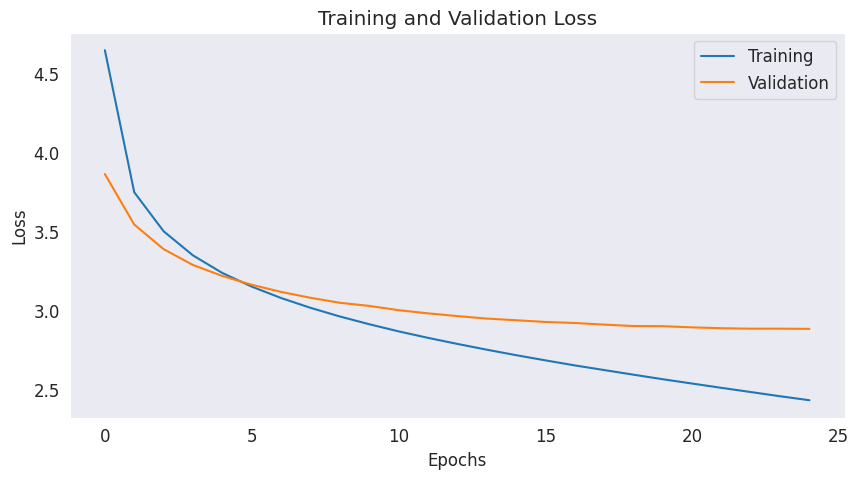

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(t_losses, label="Training")
plt.plot(v_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Generating and Vocalizing Captions for Images Using our Best Model

This code is designed for generating captions for images using our best model and then converting the captions into speech. Here's an overview:

1. **Model Loading**: Our best model is loaded from a saved file.

2. **Token Initialization**: Tokens (start, end, and pad) are initialized using a dictionary mapping words to indices.

3. **Image Embeddings**: Previouly stored image embeddings for the validation set are loaded.

4. **Caption Generation Function (`generate_caption`)**:
   - This function takes the number of top predictions to consider (`K`) and an image name, then displays the image.
   - The model is set to evaluation mode and processes the image embedding.
   - A loop generates a caption by predicting one word at a time, choosing from the top `K` predictions, until the end token is predicted or the maximum sequence length is reached.

5. **Text-to-Speech Conversion**:
   - The generated caption is converted into speech using Google's Text-to-Speech (`gTTS`) library.
   - The audio is played back as an output.

This project effectively combines image captioning and speech synthesis, showcasing an end-to-end pipeline from visual input to auditory output.

In [ ]:
model = torch.load('./BestModel')

start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 44
print(start_token, end_token, pad_token)

1 2 0


In [ ]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [ ]:
def generate_caption(K, img_nm):
    img_loc = str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis
    plt.show()


    model.eval()
    img_embed = valid_img_embed[img_nm].to(device)

    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

    input_seq = [pad_token] * max_seq_len
    input_seq[0] = start_token
    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []

    with torch.no_grad():
        for eval_iter in range(max_seq_len):
            output, padding_mask = model.forward(img_embed, input_seq)
            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]
            next_word = index_to_word[next_word_index]

            predicted_sentence.append(next_word)
            if next_word == '<end>':
                break

            input_seq[:, eval_iter + 1] = next_word_index

    text = " ".join(predicted_sentence).replace('<end>', '').strip() + '.'
    print("Generated caption: ", text)
    return text


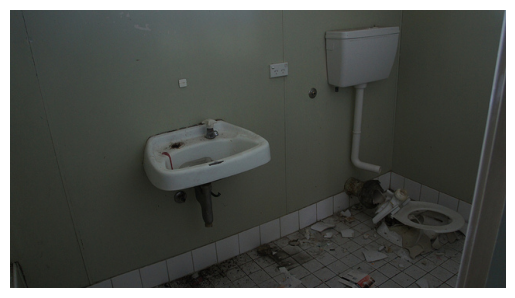

Generated caption:  bathroom with toilet and sink.


In [ ]:
#!pip install gTTS
import time
from gtts import gTTS
import io
from IPython.display import Audio

cap = generate_caption(1, unq_valid_imgs.iloc[6]['image'])

tts = gTTS(cap)
mp3_fp = io.BytesIO()
tts.write_to_fp(mp3_fp)
mp3_fp.seek(0)
time.sleep(1.5)
Audio(mp3_fp.read(),autoplay=True)

## More examples of output

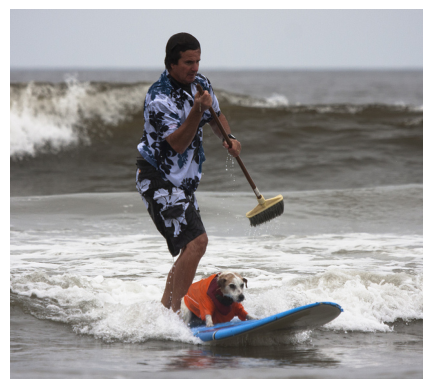

Generated caption:  man riding surf board on wave.


In [ ]:
cap = generate_caption(1, unq_valid_imgs.iloc[3423]['image'])
tts = gTTS(cap)
mp3_fp = io.BytesIO()
tts.write_to_fp(mp3_fp)
mp3_fp.seek(0)
time.sleep(1.5)
Audio(mp3_fp.read(),autoplay=True)

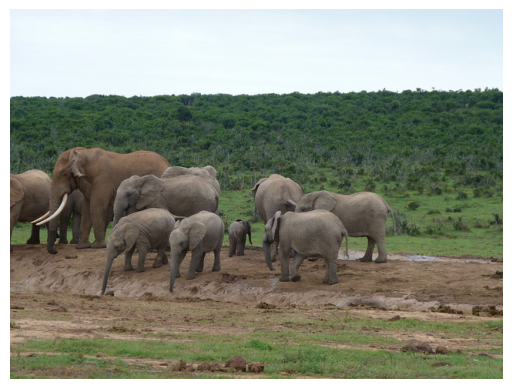

Generated caption:  herd of elephants standing in field.


In [ ]:
cap = generate_caption(1, unq_valid_imgs.iloc[879]['image'])
tts = gTTS(cap)
mp3_fp = io.BytesIO()
tts.write_to_fp(mp3_fp)
mp3_fp.seek(0)
time.sleep(1.5)
Audio(mp3_fp.read(),autoplay=True)

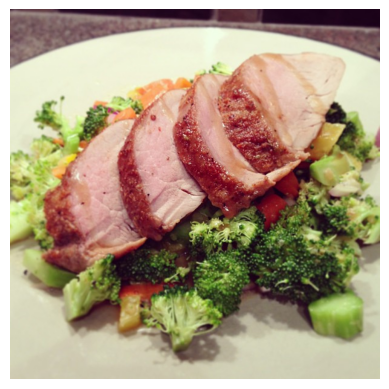

Generated caption:  plate of food with broccoli and.


In [ ]:
cap = generate_caption(1, unq_valid_imgs.iloc[2391]['image'])
tts = gTTS(cap)
mp3_fp = io.BytesIO()
tts.write_to_fp(mp3_fp)
mp3_fp.seek(0)
time.sleep(1.5)
Audio(mp3_fp.read(),autoplay=True)

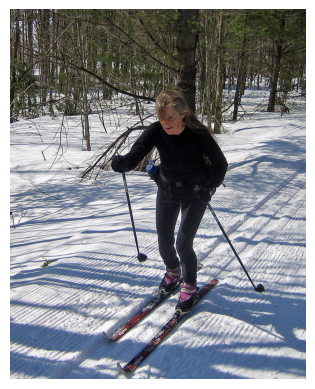

Generated caption:  woman on skis in the snow.


In [ ]:
cap = generate_caption(1, unq_valid_imgs.iloc[6004]['image'])

tts = gTTS(cap)
mp3_fp = io.BytesIO()
tts.write_to_fp(mp3_fp)
mp3_fp.seek(0)
time.sleep(1.5)
Audio(mp3_fp.read(),autoplay=True)

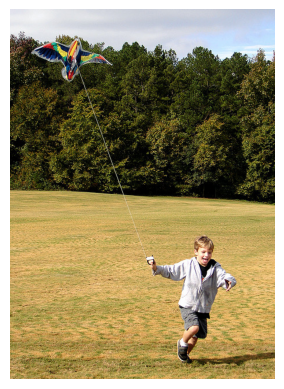

Generated caption:  man flying kite in field.


In [ ]:
cap = generate_caption(1, unq_valid_imgs.iloc[3289]['image'])

tts = gTTS(cap)
mp3_fp = io.BytesIO()
tts.write_to_fp(mp3_fp)
mp3_fp.seek(0)
time.sleep(1.5)
Audio(mp3_fp.read(),autoplay=True)

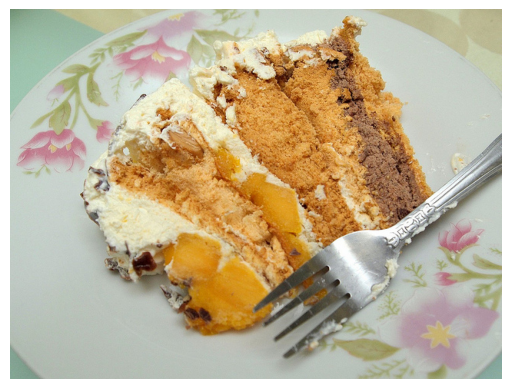

Generated caption:  piece of cake with fork and fork on.


In [ ]:
cap = generate_caption(1, unq_valid_imgs.iloc[47]['image'])

tts = gTTS(cap)
mp3_fp = io.BytesIO()
tts.write_to_fp(mp3_fp)
mp3_fp.seek(0)
time.sleep(1.5)
Audio(mp3_fp.read(),autoplay=True)

In [ ]:
cap = generate_caption(1, unq_valid_imgs.iloc[1299]['image'])

tts = gTTS(cap)
mp3_fp = io.BytesIO()
tts.write_to_fp(mp3_fp)
mp3_fp.seek(0)
time.sleep(1.5)
Audio(mp3_fp.read(),autoplay=True)

Generated caption:  an airplane is parked on the runway at the.
